In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data

from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

# Uncertainty

## Types of uncertainty

### Epistemic uncertainty

### Aleatory uncertainty





# Some existing methods for modelling uncertainty

## Monte Carlo Dropout

## Distributional Parameter Learning

## Ensemble Averaging

## Dropout Ensembles

## Quantile Regression


# Uncertainty modelling example

## Function

$$ y_i = f(x_i) + \epsilon_i, \hspace{1cm} \epsilon_i \sim \mathcal{N}(0,\sigma^2)$$


In [87]:
N_SAMPLES = 200
SIGMA = 1  # Data standard deviation
BATCH_SIZE = 16
N_EPOCHS = 100

In [88]:
np.random.seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu

In [90]:
# Data generating function
def f(x, sigma):
    y = 2 * np.sin(x + 0.5) + 3 * np.cos(0.7 * x) #  + (0.1 * x) ** 3
    eps = np.random.normal(loc=0, scale=sigma)
    return y + eps

In [105]:
# Training data
x_1 = np.random.uniform(-10, -2, size=N_SAMPLES // 2)
x_2 = np.random.uniform(0, 7, size=N_SAMPLES // 2)
x_train = np.concatenate([x_1, x_2]).reshape(N_SAMPLES, 1)
y_train = f(x_train, sigma=SIGMA).reshape(N_SAMPLES, 1)

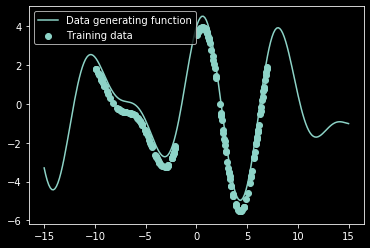

In [106]:
x_plot = np.linspace(-15, 15, num=200)
fig, ax = plt.subplots(1, 1)
ax.plot(x_plot, f(x_plot, sigma=0), label='Data generating function')
ax.scatter(x_train, y_train, label='Training data')
ax.legend()

In [ ]:
# Dataset and loader
dataset_train = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE)

In [95]:
def gaussian_nll(mu_true, mu_pred, sigma_pred):
    return np.log(sigma_pred ** 2) / 2 + ((mu_true - mu_pred) ** 2) / (2 * sigma_pred ** 2)

In [96]:
class GaussianNLLLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mu_true, mu_pred, logvar_pred):
        return torch.mean(logvar_pred / (2 * np.pi) + (mu_true - mu_pred).pow(2) / (2 * logvar_pred.exp()), axis=0)

In [100]:
class DPLModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(1, 20)
        self.bn1 = nn.BatchNorm1d(20)
        self.act1 = nn.ELU()
        self.lin2 = nn.Linear(20, 2)

    def forward(self, x):
        x = self.lin1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.lin2(x)
        mu = x[..., 0:1]
        logvar = x[..., 1:2]
        return mu, logvar

In [101]:
model = DPLModel()
model.to(device)

gaussian_nll_loss = GaussianNLLLoss()
gaussian_nll_loss.to(device)

optimizer = optim.Adam(model.parameters(), lr=3e-4)


for epoch in range(N_EPOCHS):
    total_loss = 0
    for i, (x_batch, y_batch) in enumerate(dataloader_train, start=1):
        x_batch.to(device)
        y_batch.to(device)

        optimizer.zero_grad()

        mu_pred, logvar_pred = model.forward(x_batch)
        loss = gaussian_nll_loss(y_batch, mu_pred, logvar_pred)
        loss.backward()
        optimizer.step()

        total_loss += loss[0].item()
        print(f'Epoch {epoch:3d} | Loss {total_loss / i} ({loss[0].item()})', end='\r')

Epoch  99 | Loss 0.5293437265432798 (0.6372318863868713)

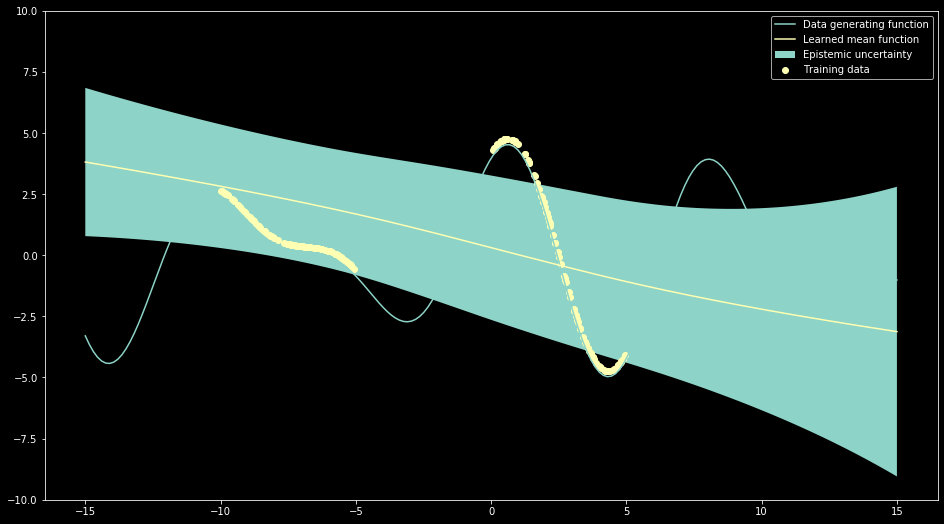

In [102]:
with torch.no_grad():
    x_plot_tensor = torch.Tensor(x_plot.reshape(-1, 1))
    x_plot_tensor.to(device)
    learned_function, epistemic_logvar = model.forward(x_plot_tensor)
    learned_function = learned_function.flatten()
    epistemic_std = epistemic_logvar.flatten().exp().sqrt()

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.plot(x_plot, f(x_plot, sigma=0), label='Data generating function')
ax.fill_between(x_plot, learned_function - epistemic_std, learned_function + epistemic_std, label='Epistemic uncertainty')
ax.scatter(x_train, y_train, label='Training data')
ax.plot(x_plot, learned_function, label='Learned mean function')
ax.set_ylim([-10, 10])
ax.legend()

In [103]:
x_train

array([[-9.19185643],
       [-5.50722906],
       [-6.9678547 ],
       [-9.95401474],
       [-9.49264229],
       [-6.68249115],
       [-9.97469208],
       [-9.19595974],
       [-7.25633105],
       [-6.54052401],
       [-6.7401937 ],
       [-8.87865345],
       [-6.43910389],
       [-8.81375456],
       [-8.37300151],
       [-6.26754297],
       [-6.7518355 ],
       [-5.75388295],
       [-6.71193554],
       [-7.15845698],
       [-9.53162616],
       [-8.16142098],
       [-8.67398816],
       [-8.78005178],
       [-5.13494723],
       [-8.03451138],
       [-5.53976722],
       [-6.84430687],
       [-6.02594348],
       [-7.48681453],
       [-7.11548058],
       [-7.53741153],
       [-9.02378506],
       [-6.38773942],
       [-8.59613819],
       [-9.87842017],
       [-6.77263852],
       [-9.1144466 ],
       [-5.29770708],
       [-5.23035711],
       [-5.42567805],
       [-8.1492065 ],
       [-9.92271692],
       [-5.35840719],
       [-7.85907926],
       [-5

In [104]:
y_train

array([[ 1.85997791],
       [-0.12233995],
       [ 0.35809105],
       [ 2.61468764],
       [ 2.20055921],
       [ 0.32938713],
       [ 2.62830715],
       [ 1.86477908],
       [ 0.39744653],
       [ 0.31196335],
       [ 0.33545016],
       [ 1.49431751],
       [ 0.29616863],
       [ 1.42062508],
       [ 0.96932669],
       [ 0.26020528],
       [ 0.33662931],
       [ 0.04887855],
       [ 0.33253177],
       [ 0.38155231],
       [ 2.24197022],
       [ 0.79461316],
       [ 1.26700534],
       [ 1.38288917],
       [-0.47132513],
       [ 0.70521448],
       [-0.09695609],
       [ 0.3457212 ],
       [ 0.18303495],
       [ 0.45068313],
       [ 0.37553087],
       [ 0.46600728],
       [ 1.66268663],
       [ 0.28675493],
       [ 1.18518568],
       [ 2.56063009],
       [ 0.33870931],
       [ 1.76914116],
       [-0.30588781],
       [-0.37203734],
       [-0.1896823 ],
       [ 0.78549647],
       [ 2.59310291],
       [-0.24918932],
       [ 0.60109994],
       [-0